In [600]:
#Importing the dependancies we will need. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [601]:
#Reads data from Melbourne Housing and Poperty Sales of Melbourne City. 
dataset1 = pd.read_csv("datasets/Melbourne_housing_FULL.csv")
dataset2 = pd.read_csv("datasets/PSMS.csv")

In [602]:
#Takes our two datasets and merges them together into one. 
Merged_Data = pd.merge(dataset1,dataset2,how='outer')

In [603]:
# Exploring the shape of our initial dataset. Output shows that our intial dataset has 53K rows. 
# Also looking at NaN values which shows that a lot of values are missing for our data. 
Merged_Data.shape
Merged_Data.isnull().sum()


Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             2
Postcode             2
Bedroom2         11686
Bathroom         11697
Car              12304
Landsize         16603
BuildingArea     31749
YearBuilt        28744
CouncilArea       6166
Lattitude        11308
Longtitude       11308
Regionname           4
Propertycount        4
KeyID            34857
dtype: int64

In [604]:
# To start processing we are going to drop irrellevant columns that we think don't correlate to price and will make our model perform worse. 
# We are also doing this now to hopefully thing down the amount of potential NaN values in our dataset which we will remove in the next step.
# Finally, we will drop any duplicates. This narrows our dataset to roughly 34K values. 
Data = Merged_Data.drop(["Date","Lattitude", "Suburb", "KeyID","Address", "Method", "SellerG","Postcode", "CouncilArea", "YearBuilt"], axis = 1)
Data.drop_duplicates(inplace = True)
Data.shape

(33942, 12)

In [605]:
# We want to drop any Not a number values from our dataset but doing so as the data stands now will leave us with only 9K values to train our model off. 
# Let's explore where these NaN values are coming from again, and decide how we will deal with them.
Data.isnull().sum()

Rooms                0
Type                 0
Price             6877
Distance             2
Bedroom2          7344
Bathroom          7353
Car               7855
Landsize         10928
BuildingArea     20225
Longtitude        7103
Regionname           4
Propertycount        4
dtype: int64

In [606]:
# Notice that 20K values dont have a building area and 10K haven't got a landsize. 
# These are definitely correlative to price which is our target value but we cant use them. 
# We can handle this by filling the rows with some value. 
# We could use the average, but for a dataset like ours and given the model we want to build it doesnt really make sense to do that
# The range is much too large and would give us a lot of inaccurate rows. 


In [607]:
# Instead lets try and use K-means nearest neighbour method that will fill missing values based on similar rows in the dataset. 

from sklearn.impute import KNNImputer

SimilarFeatures = ['Landsize', 'Bedroom2', 'Rooms', 'BuildingArea']
Imputer = KNNImputer(n_neighbors=5)
DataSubset = Data[SimilarFeatures]
Data_imputed = Imputer.fit_transform(DataSubset)
Data_imputed = pd.DataFrame(Data_imputed, columns=SimilarFeatures)
Data['BuildingArea'] = Data['BuildingArea'].fillna(Data_imputed['BuildingArea'])



In [608]:
# From this we successfully recovered about 13 thousand values from the BuildingArea column, lets do some other important columns now too. 
Data.isnull().sum()


Rooms                0
Type                 0
Price             6877
Distance             2
Bedroom2          7344
Bathroom          7353
Car               7855
Landsize         10928
BuildingArea      7370
Longtitude        7103
Regionname           4
Propertycount        4
dtype: int64

In [609]:
SimilarFeatures = ['Landsize', 'Bedroom2', 'Rooms', 'BuildingArea']
imputer = KNNImputer(n_neighbors=5)
DataSubset = Data[SimilarFeatures]
Data_imputed = imputer.fit_transform(DataSubset)
Data_imputed = pd.DataFrame(Data_imputed, columns=SimilarFeatures)
Data['Landsize'] = Data['Landsize'].fillna(Data_imputed['Landsize'])



In [610]:
# We recovered another 7k values. 
Data.isnull().sum()


Rooms               0
Type                0
Price            6877
Distance            2
Bedroom2         7344
Bathroom         7353
Car              7855
Landsize         3950
BuildingArea     7370
Longtitude       7103
Regionname          4
Propertycount       4
dtype: int64

In [611]:
#Now that we have recovered some data let's drop the NaN values.
# By using the K-Nearest method to fill in some missing values we improved the volume of data to train our dataset on. 

Cleaned_data = Data.dropna()
Cleaned_data.shape

(16256, 12)

In [612]:
# Looking at the data we have left we notice that there are two columns with non integer datatypes. 
# We need to use the get_dummies method from the pandas library to encode it into a useable format. 
Cleaned_data

,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Longtitude,Regionname,Propertycount
0,2,h,1075000.0,3.0,2.0,1.0,0.0,299.0,92.0,145.00067,Northern Metropolitan,4019.0
2,3,u,1001000.0,3.0,3.0,2.0,1.0,720.4,221.8,144.99834,Northern Metropolitan,4019.0
4,2,u,505000.0,3.0,2.0,1.0,1.0,0.0,38.0,145.00015,Northern Metropolitan,4019.0
6,4,t,1525000.0,3.0,4.0,2.0,2.0,102.0,75.0,145.00066,Northern Metropolitan,4019.0
8,2,h,940000.0,3.0,2.0,1.0,0.0,424.0,86.6,144.99339,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53231,3,h,1190000.0,6.3,3.0,1.0,2.0,515.0,89.0,144.87725,Western Metropolitan,6543.0
53236,3,h,796000.0,7.0,3.0,1.0,1.0,464.0,120.0,144.86380,Western Metropolitan,6543.0
53238,3,h,955000.0,7.0,3.0,2.0,2.0,206.0,173.0,144.89650,Western Metropolitan,6543.0
53240,2,u,381000.0,7.0,2.0,1.0,1.0,0.0,65.0,144.89530,Western Metropolitan,6543.0


In [613]:
#Encoding the regionname column 
Cleaned_data = pd.get_dummies(Cleaned_data, columns = ["Regionname"]) 

In [614]:
#Encoding the Type into a binary format. H = house, T =  townhouse, U = unit  
Cleaned_data = pd.get_dummies(Cleaned_data, columns = ["Type"])

In [615]:
# Now we are going to begin training the model. We first start by splitting the data into training and test data using the sklearn library. 

from sklearn.model_selection import train_test_split

X = Cleaned_data.drop(['Price'], axis = 1)
Y = Cleaned_data['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [616]:
# Because the train test split function splits the data into 4 sets we need to rejoin the training data back together. 
training_data = X_train.join(Y_train)

<Axes: >

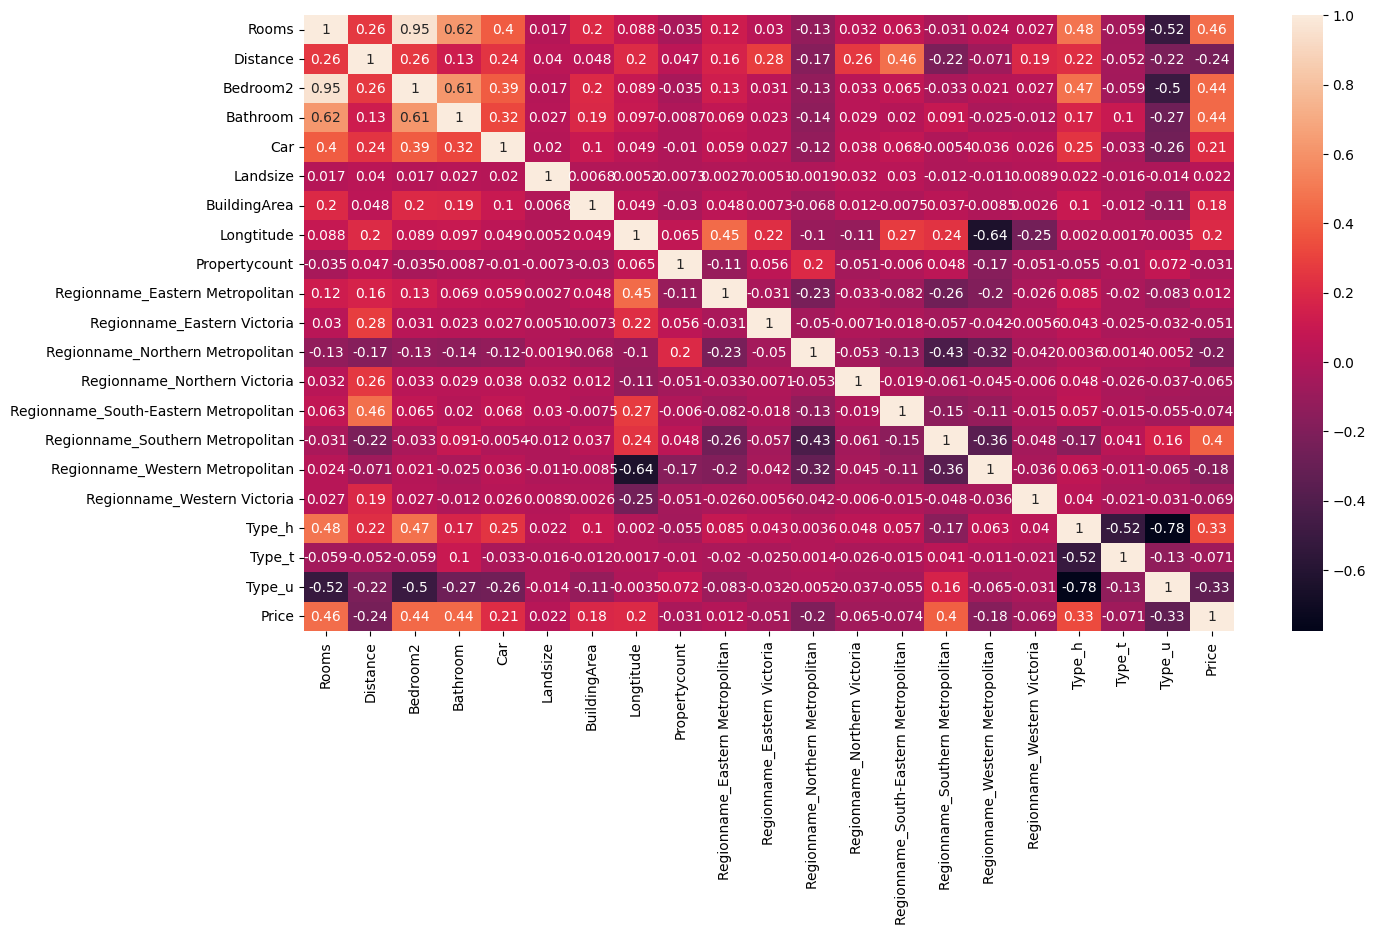

In [617]:
# Before moving futher we'll visualise the data. 
# Lets look at how different variables correlate to price. The Seaborn heatmap is a great way to view this.   

plt.figure(figsize = (15,8))
sns.heatmap(training_data.corr(), annot=True)

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'Propertycount'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 2500x1000 with 0 Axes>

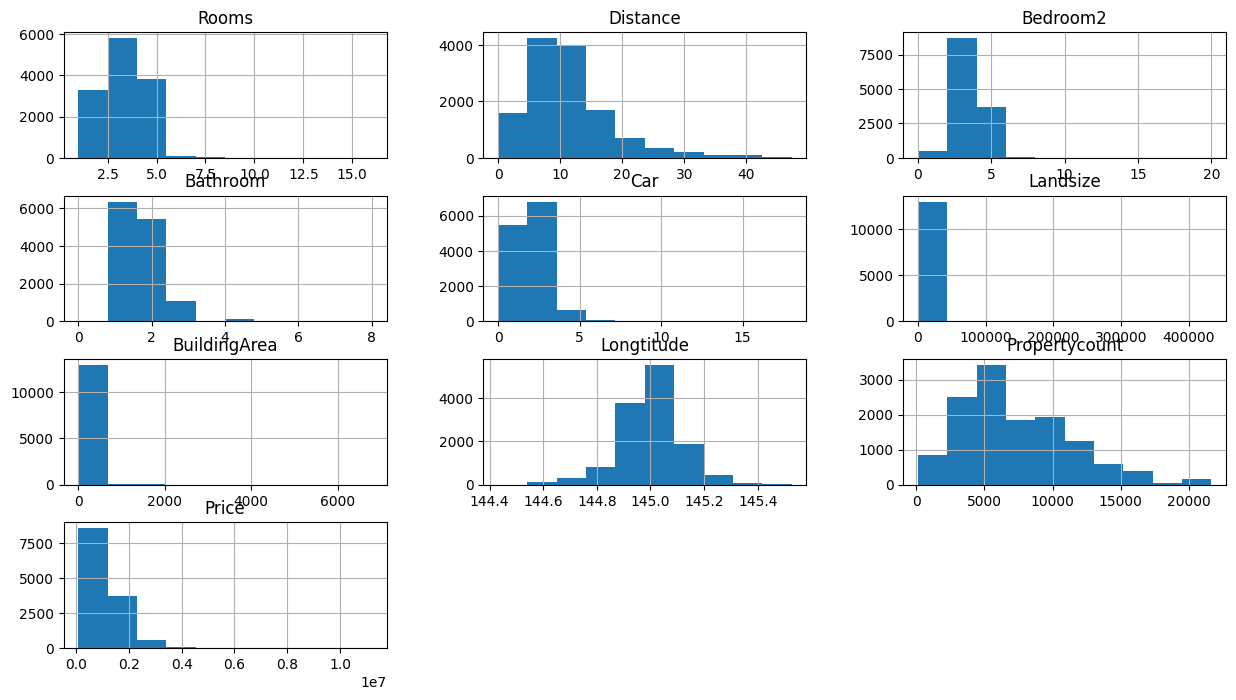

In [618]:
# Now lets look at how our data looks on a histogram. 
plt.figure(figsize=(25,10))
training_data.hist(figsize=(15,8))

In [619]:
# Our Features are somewhat skewed, ideally we want a bell curve type distubtion 
# To do this we will be Normalising the data using logirithm from the numpy library. 
training_data['Rooms'] = np.log (training_data['Rooms']+1)
training_data['Distance'] = np.log (training_data['Distance']+1)
training_data['Price'] = np.log (training_data['Price']+1)
training_data['Bedroom2'] = np.log (training_data['Bedroom2']+1)
training_data['Landsize'] = np.log (training_data['Landsize']+1)
training_data['BuildingArea'] = np.log (training_data['BuildingArea']+1)
training_data['Longtitude'] = np.log (training_data['Longtitude']+1)
training_data['Car'] = np.log (training_data['Car']+1)
training_data['Bathroom'] = np.log (training_data['Bathroom']+1)




array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'Propertycount'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >]],
      dtype=object)

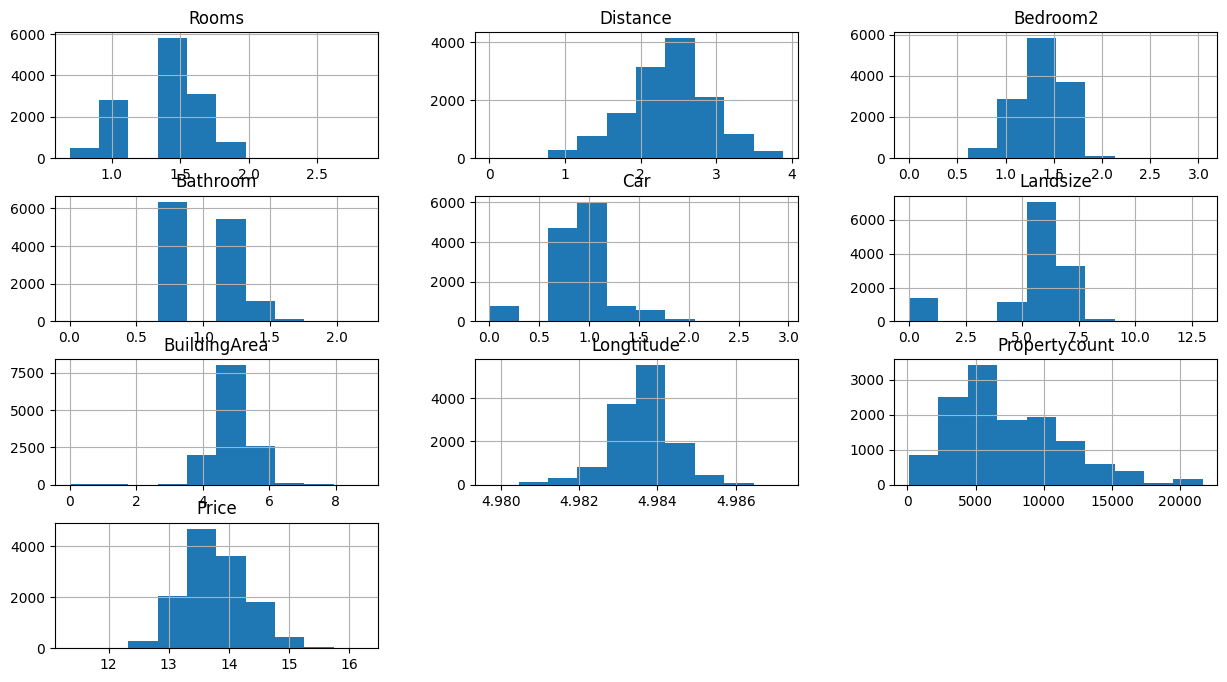

In [620]:
#Showing data after normalising with logarithms. 
training_data.hist(figsize=(15,8))

In [621]:
# Now that we have normalised the training data we can seperate our target variable from our dataset and place it in the X_train_transform variable
# On the y variable we make it just the price variable. 
X_train_transformed = training_data.drop(columns=['Price'])
Y_train_transformed = training_data['Price']



In [622]:
# Now we have what we need to build a  Linear Regression model we start by importing it in, 
# Next we name it as a variable so that we can train it later using the fit method. 
# Before we train the model we want to scale our data.

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
regression_model = LinearRegression()
scaler = StandardScaler()
X_train_s= scaler.fit_transform(X_train_transformed)
regression_model.fit(X_train_s,Y_train_transformed)

LinearRegression()

In [623]:
# Now we want to configure our test data. 
# Like before we join the X and Y and then Normalise our test data using logarithms. 

test_data = X_test.join(Y_test)

test_data['Rooms'] = np.log (test_data['Rooms']+1)
test_data['Distance'] = np.log (test_data['Distance']+1)
test_data['Price'] = np.log (test_data['Price']+1)
test_data['Bedroom2'] = np.log (test_data['Bedroom2']+1)
test_data['Landsize'] = np.log (test_data['Landsize']+1)
test_data['BuildingArea'] = np.log (test_data['BuildingArea']+1)
test_data['Landsize'] = np.log (test_data['Landsize']+1)
test_data['Car'] = np.log (test_data['Car']+1)
test_data['Bathroom'] = np.log (test_data['Bathroom']+1)

In [624]:
#And we seperate the target and predictive variable again. 

X_test_transformed = training_data.drop(columns=['Price'])
Y_test_transformed = training_data['Price']

In [625]:
# And we scale like before. 

X_test_s = scaler.transform(X_test_transformed)

In [640]:
#Testing performance of the model. Firestly evaluating the r^2 value which will giive us an indication of how well the fit is.
#  Might need to change X_Test to something else.
from sklearn import metrics 
Y_predicted = regression_model.predict(X_test_s)

r2 = regression_model.score(X_test_s,Y_test_transformed)
mae = metrics.mean_absolute_error(Y_test_transformed, Y_predicted)
m2e = metrics.mean_squared_error(Y_test_transformed, Y_predicted)
rmse = np.sqrt(metrics.mean_absolute_error(Y_test_transformed, Y_predicted))

print("The coefficient of determination of the model is: " + str(r2))
print("The Mean absolute error of the model is: " + str(mae))
print("The Mean squared error regression loss of the model is: " + str(m2e))
print("The Root mean squared of the model is: " + str(rmse))

The coefficient of determination of the model is: 0.7327706313751134
The Mean absolute error of the model is: 0.21164917021446325
The Mean squared error regression loss of the model is: 0.07568011377405684
The Root mean squared of the model is: 0.46005344278079613


array([[ 0.03152297,  0.58296536, -1.11915117, ...,  0.57829742,
        -0.30049845, -0.44902819],
       [ 0.03152297,  0.44162103,  0.04993402, ...,  0.57829742,
        -0.30049845, -0.44902819],
       [ 0.03152297,  1.71240013,  0.04993402, ...,  0.57829742,
        -0.30049845, -0.44902819],
       ...,
       [ 0.03152297,  0.3874113 ,  0.04993402, ...,  0.57829742,
        -0.30049845, -0.44902819],
       [ 0.03152297,  0.28852946,  0.04993402, ...,  0.57829742,
        -0.30049845, -0.44902819],
       [-1.15490051, -1.98438296, -5.58370242, ..., -1.72921399,
        -0.30049845,  2.22703166]])

In [639]:

input_values = [] 
regression_model.predict(input_values)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [594]:
# The score above was good, but maybe we can improve it by using a random forest regressor. 

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, Y_train_transformed)

RandomForestRegressor()

In [632]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#prediction = forest.predict(X_test)
#accuracy = accuracy_score(Y_test, prediction)
#precision = precision_score(Y_test, prediction, average='weighted')
#recall = recall_score(Y_test, prediction, average='weighted')
#f1 = f1_score(Y_test, prediction, average='weighted')
           
#print("The accuracy of the model is: " + str(accuracy))
#print("The precision of the model is: " + str(precision))
#print("The recall of the model is: " + str(recall))
#print("The f1 of the model is: " + str(f1))
print(forest.score(X_test_s,Y_test_transformed))
forest.predict(X_test_s)

0.9476288840531774


array([13.71993527, 13.67612081, 13.38801718, ..., 13.43620149,
       13.67748712, 13.18189773])

In [522]:
from sklearn.model_selection import GridSearchCV

grid = {
    "n_estimators": [3,10,30],
    "max_features": [2,4,6,8],
}

grid_search = GridSearchCV(forest, grid, cv = 5,
                           return_train_score= True,
                           scoring="neg_mean_squared_error")

grid_search.fit(X_train_s, Y_train)


AttributeError: 'RandomForestRegressor' object has no attribute 'grid'

In [516]:
best_forest = grid_search.best_estimator_
best_forest.score(X_test_s, Y_test_transformed)

-5817823655526.632